In [15]:
%matplotlib inline
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sn
import pandas as pd
import random as rd
import datetime as dt

from bigdl.dataset.transformer import *
from bigdl.dataset.base import *
from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util.common import *
from utils import *

from pyspark.sql.functions import col

LABELS = ["Setosa", "Virginica", "Versicolor"]


init_engine()

In [16]:
learning_rate = 0.01
training_epochs = 50
batch_size = 16
display_step = 1

# Network Parameters
## TODO: Should I adjust any of these parameters?
n_input = 4
n_classes = 3
n_hidden_1 = 10 # 1st layer number of features
n_hidden_2 = 20 # 2nd layer number of features
n_hidden_3 = 10 # 3rd layer number of features

In [17]:
iris_training = spark.read.csv("../data/iris/iris_training.csv", header=True, inferSchema="true", mode="DROPMALFORMED")
iris_test = spark.read.csv("../data/iris/iris_test.csv", header=True, inferSchema="true", mode="DROPMALFORMED")

In [18]:
iris_training = iris_training.select([col(c).cast("double") for c in iris_training.columns])
iris_test = iris_test.select([col(c).cast("double") for c in iris_test.columns])



In [19]:
iris_k_train = iris_training.rdd.map(list)
iris_k_test = iris_test.rdd.map(list)

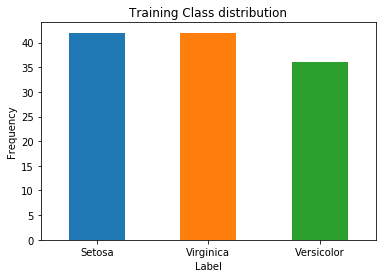

In [20]:
count_classes = pd.value_counts(iris_training.select('label').toPandas()['label'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Training Class distribution")
plt.xticks(range(n_classes), LABELS)
plt.xlabel("Label")
plt.ylabel("Frequency");

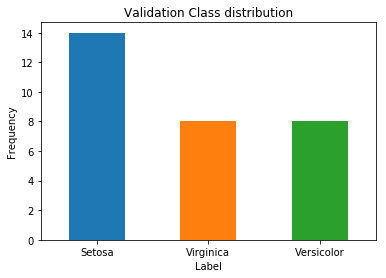

In [21]:
count_classes = pd.value_counts(iris_test.select('label').toPandas()['label'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Validation Class distribution")
plt.xticks(range(n_classes), LABELS)
plt.xlabel("Label")
plt.ylabel("Frequency");

In [22]:
iris_k_train.take(29)

[[6.4, 2.8, 5.6, 2.2, 3.0],
 [5.0, 2.3, 3.3, 1.0, 2.0],
 [4.9, 2.5, 4.5, 1.7, 3.0],
 [4.9, 3.1, 1.5, 0.1, 1.0],
 [5.7, 3.8, 1.7, 0.3, 1.0],
 [4.4, 3.2, 1.3, 0.2, 1.0],
 [5.4, 3.4, 1.5, 0.4, 1.0],
 [6.9, 3.1, 5.1, 2.3, 3.0],
 [6.7, 3.1, 4.4, 1.4, 2.0],
 [5.1, 3.7, 1.5, 0.4, 1.0],
 [5.2, 2.7, 3.9, 1.4, 2.0],
 [6.9, 3.1, 4.9, 1.5, 2.0],
 [5.8, 4.0, 1.2, 0.2, 1.0],
 [5.4, 3.9, 1.7, 0.4, 1.0],
 [7.7, 3.8, 6.7, 2.2, 3.0],
 [6.3, 3.3, 4.7, 1.6, 2.0],
 [6.8, 3.2, 5.9, 2.3, 3.0],
 [7.6, 3.0, 6.6, 2.1, 3.0],
 [6.4, 3.2, 5.3, 2.3, 3.0],
 [5.7, 4.4, 1.5, 0.4, 1.0],
 [6.7, 3.3, 5.7, 2.1, 3.0],
 [6.4, 2.8, 5.6, 2.1, 3.0],
 [5.4, 3.9, 1.3, 0.4, 1.0],
 [6.1, 2.6, 5.6, 1.4, 3.0],
 [7.2, 3.0, 5.8, 1.6, 3.0],
 [5.2, 3.5, 1.5, 0.2, 1.0],
 [5.8, 2.6, 4.0, 1.2, 2.0],
 [5.9, 3.0, 5.1, 1.8, 3.0],
 [5.4, 3.0, 4.5, 1.5, 2.0]]

In [23]:
#convert ndarray data into RDD[Sample]
def array2rdd(ds):
    #build Sample from ndarrays
    def build_sample(c0,c1,c2,c3,prediction):
        feature = np.array([c0,c1, c2, c3]).flatten()
        label = np.array(prediction)
        return Sample.from_ndarray(feature, label)
    rdd = ds.map(lambda (c0,c1,c2,c3,prediction): build_sample(c0,c1,c2,c3,prediction))
    return rdd

iris_rdd_train = array2rdd(iris_k_train)
iris_rdd_train.cache()
print("Training Count: " + str(iris_rdd_train.count()))

iris_rdd_test = array2rdd(iris_k_test)
iris_rdd_test.cache()
print ("Test Count: " + str(iris_rdd_test.count()))

Training Count: 120
Test Count: 30


In [24]:
# Create model

def multilayer_perceptron(n_hidden_1, n_hidden_2, n_hidden_3, n_input, n_classes):
    # Initialize a sequential container
    model = Sequential()
    # Hidden layer with ReLu activation
    model.add(Linear(n_input, n_hidden_1).set_name('mlp_fc1'))
    model.add(ReLU())
    # Hidden layer with ReLu activation
    model.add(Linear(n_hidden_1, n_hidden_2).set_name('mlp_fc2'))
    model.add(ReLU())
     # Hidden layer with ReLu activation
    model.add(Linear(n_hidden_2, n_hidden_3).set_name('mlp_fc3'))
    model.add(ReLU())
    # output layer
    model.add(Linear(n_hidden_3, n_classes).set_name('mlp_fc4'))
    model.add(LogSoftMax())
    return model

model = multilayer_perceptron(n_hidden_1, n_hidden_2, n_hidden_3, n_input, n_classes)

creating: createSequential
creating: createLinear
creating: createReLU
creating: createLinear
creating: createReLU
creating: createLinear
creating: createReLU
creating: createLinear
creating: createLogSoftMax


In [25]:
# Create an Optimizer
optimizer = Optimizer(
    model=model,
    training_rdd=iris_rdd_train,
    criterion=ClassNLLCriterion(),
    optim_method=SGD(learningrate=learning_rate),
    end_trigger=MaxEpoch(training_epochs),
    batch_size=batch_size)

# Set the validation logic
optimizer.set_validation(
    batch_size=batch_size,
    val_rdd=iris_rdd_test,
    trigger=EveryEpoch(),
    val_method=[Top1Accuracy()]
)

app_name='multilayer_perceptron-'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
train_summary = TrainSummary(log_dir='/tmp/bigdl_summaries',
                                     app_name=app_name)
train_summary.set_summary_trigger("Parameters", SeveralIteration(50))
val_summary = ValidationSummary(log_dir='/tmp/bigdl_summaries',
                                        app_name=app_name)
optimizer.set_train_summary(train_summary)
optimizer.set_val_summary(val_summary)
print("saving logs to ",app_name)

creating: createClassNLLCriterion
creating: createDefault
creating: createSGD
creating: createMaxEpoch
creating: createOptimizer
creating: createEveryEpoch
creating: createTop1Accuracy
creating: createTrainSummary
creating: createSeveralIteration
creating: createValidationSummary
('saving logs to ', 'multilayer_perceptron-20171111-153701')


In [26]:
%%time
# Boot training process
trained_model = optimizer.optimize()
print("Optimization Done.")

Optimization Done.
CPU times: user 50 ms, sys: 110 ms, total: 160 ms
Wall time: 3min 35s


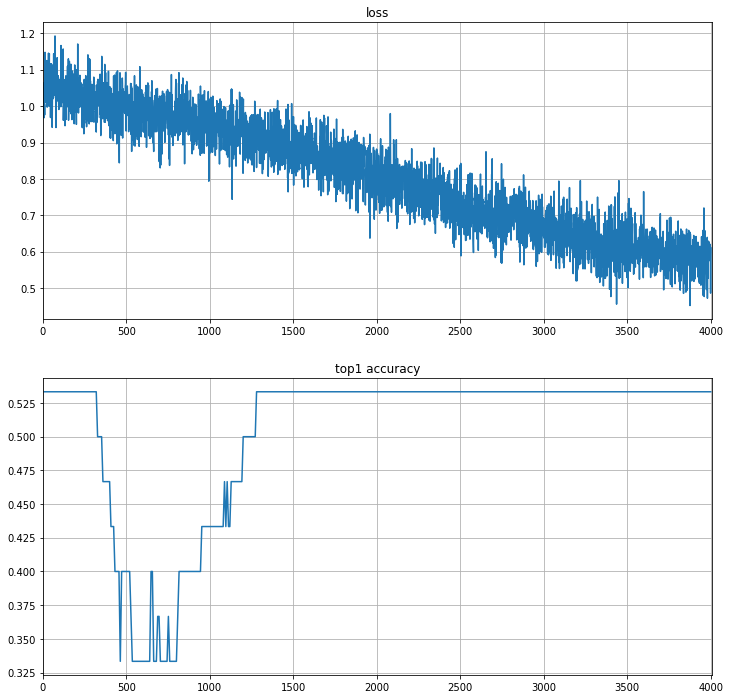

In [27]:
loss = np.array(train_summary.read_scalar("Loss"))
top1 = np.array(val_summary.read_scalar("Top1Accuracy"))

plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.plot(loss[:,0],loss[:,1],label='loss')
plt.xlim(0,loss.shape[0]+10)
plt.grid(True)
plt.title("loss")
plt.subplot(2,1,2)
plt.plot(top1[:,0],top1[:,1],label='top1')
plt.xlim(0,loss.shape[0]+10)
plt.title("top1 accuracy")
plt.grid(True)


In [28]:
# TODO: Why don't we see any convergence in the loss function?  
# It just seems to bounce up and down?

In [29]:
predictions = trained_model.predict(iris_rdd_test).collect()

def map_predict_label(l):
    return np.array(l).argmax()
def map_groundtruth_label(l):
    return l.to_ndarray()[0] - 1

y_pred = np.array([ map_predict_label(s) for s in predictions])

y_true = np.array([map_groundtruth_label(s.label) for s in iris_rdd_test.collect()])

The prediction accuracy is 53.33%


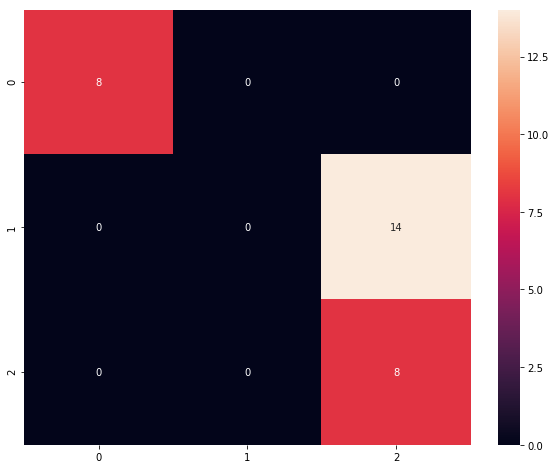

In [30]:
acc = accuracy_score(y_true, y_pred)
print("The prediction accuracy is %.2f%%"%(acc*100))

cm = confusion_matrix(y_true, y_pred)
cm.shape
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (10,8))
sn.heatmap(df_cm, annot=True,fmt='d');

In [31]:
## TODO: Something didn't work very well.